In [1]:
import os
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

from m5.read import build_base_dataset
from m5.metric import WRMSSE
from m5.constants import ID_COLUMNS
from m5.funcs import only_days_columns

# Подготовка набора данных

In [3]:
ds = build_base_dataset()

In [4]:
ds['sold_r7s28mean'] = ds['sold'].rolling(7).mean().shift(28)
ds['sold_r28s28mean'] = ds['sold'].rolling(28).mean().shift(28)
ds['sold_r183s28mean'] = ds['sold'].rolling(183).mean().shift(28)
ds['sold_r365s28mean'] = ds['sold'].rolling(365).mean().shift(28)
ds['sold_r365s183mean'] = ds['sold'].rolling(365).mean().shift(183)
ds['sold_r365s365mean'] = ds['sold'].rolling(365).mean().shift(365)

In [5]:
ds['price_r7s28mean'] = ds['sell_price'].rolling(7).mean().shift(28)
ds['price_r28s28mean'] = ds['sell_price'].rolling(28).mean().shift(28)
ds['price_r183s28mean'] = ds['sell_price'].rolling(183).mean().shift(28)
ds['price_r365s28mean'] = ds['sell_price'].rolling(365).mean().shift(28)
ds['price_r365s183mean'] = ds['sell_price'].rolling(365).mean().shift(183)
ds['price_r365s365mean'] = ds['sell_price'].rolling(365).mean().shift(365)

# Обучение модели

In [10]:
CATEGORICAL_FEATURES = [
    'dept_id', 'cat_id', 'store_id', 'state_id',
    'weekday', 'month', 'year'
]
NUMERICAL_FEATURES = [
    'sell_price', 
    'sold_r7s28mean', 'sold_r28s28mean', 'sold_r183s28mean', 'sold_r365s28mean', 'sold_r365s183mean', 'sold_r365s365mean',
    'price_r7s28mean', 'price_r28s28mean', 'price_r183s28mean', 'price_r365s28mean', 'price_r365s183mean', 'price_r365s365mean',
]

XS = CATEGORICAL_FEATURES + NUMERICAL_FEATURES
TARGET = 'sold'

In [7]:
train_ds = ds[ds['d'] < 1914]
val_ds = ds[ds['d'] >= 1914]

In [8]:
# объект для подсчета метрик
metric = WRMSSE(train_ds, val_ds)

[2020-06-18 14:20:04,396] INFO: Calculate profit
[2020-06-18 14:20:22,695] INFO: Transform train to standard view
[2020-06-18 14:21:59,591] INFO: Transform validation to standard view
[2020-06-18 14:22:00,218] INFO: Calculate levels specification
100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


In [ ]:
# объекты для обучения
train_set = lgb.Dataset(train_ds[XS], train_ds[TARGET], categorical_feature=CATEGORICAL_FEATURES)
valid_set = lgb.Dataset(val_ds[XS], val_ds[TARGET], categorical_feature=CATEGORICAL_FEATURES)


In [12]:
params = {
    'objective': 'rmse',
    'num_iterations': 5000,
    'learning_rate': 0.1,
    'verbose': 20,
'    bagging_fraction': 0.5,
    'feature_fraction': 0.7,
    'max_depth': 8,
    'num_leaves': 32
}

In [13]:
model = lgb.train(
    params,
    train_set=train_set,
    valid_sets=[train_set, valid_set],
    early_stopping_rounds=10,
    categorical_feature=CATEGORICAL_FEATURES
)

[1]	training's rmse: 3.85662	valid_1's rmse: 3.62874
Training until validation scores don't improve for 10 rounds.
[2]	training's rmse: 3.79391	valid_1's rmse: 3.57391
[3]	training's rmse: 3.74082	valid_1's rmse: 3.51252
[4]	training's rmse: 3.72985	valid_1's rmse: 3.49881
[5]	training's rmse: 3.72186	valid_1's rmse: 3.48823
[6]	training's rmse: 3.67733	valid_1's rmse: 3.43628
[7]	training's rmse: 3.67182	valid_1's rmse: 3.42827
[8]	training's rmse: 3.63529	valid_1's rmse: 3.39164
[9]	training's rmse: 3.60582	valid_1's rmse: 3.36431
[10]	training's rmse: 3.57827	valid_1's rmse: 3.34609
[11]	training's rmse: 3.57551	valid_1's rmse: 3.34269
[12]	training's rmse: 3.55238	valid_1's rmse: 3.32767
[13]	training's rmse: 3.55018	valid_1's rmse: 3.32466
[14]	training's rmse: 3.53237	valid_1's rmse: 3.2906
[15]	training's rmse: 3.51689	valid_1's rmse: 3.2682
[16]	training's rmse: 3.50239	valid_1's rmse: 3.24296
[17]	training's rmse: 3.50047	valid_1's rmse: 3.23972
[18]	training's rmse: 3.48901	v

[152]	training's rmse: 3.27217	valid_1's rmse: 2.89144
[153]	training's rmse: 3.27164	valid_1's rmse: 2.89125
[154]	training's rmse: 3.27018	valid_1's rmse: 2.88868
[155]	training's rmse: 3.26946	valid_1's rmse: 2.88773
[156]	training's rmse: 3.26879	valid_1's rmse: 2.88718
[157]	training's rmse: 3.26603	valid_1's rmse: 2.88676
[158]	training's rmse: 3.26569	valid_1's rmse: 2.88723
[159]	training's rmse: 3.26528	valid_1's rmse: 2.8868
[160]	training's rmse: 3.26375	valid_1's rmse: 2.88679
[161]	training's rmse: 3.26345	valid_1's rmse: 2.88654
[162]	training's rmse: 3.26317	valid_1's rmse: 2.88648
[163]	training's rmse: 3.26289	valid_1's rmse: 2.8853
[164]	training's rmse: 3.26243	valid_1's rmse: 2.88307
[165]	training's rmse: 3.26178	valid_1's rmse: 2.88207
[166]	training's rmse: 3.26086	valid_1's rmse: 2.87228
[167]	training's rmse: 3.26069	valid_1's rmse: 2.87183
[168]	training's rmse: 3.26039	valid_1's rmse: 2.87157
[169]	training's rmse: 3.25973	valid_1's rmse: 2.8673
[170]	trainin

[302]	training's rmse: 3.20009	valid_1's rmse: 2.74977
[303]	training's rmse: 3.19974	valid_1's rmse: 2.74939
[304]	training's rmse: 3.19964	valid_1's rmse: 2.74907
[305]	training's rmse: 3.19866	valid_1's rmse: 2.74904
[306]	training's rmse: 3.19831	valid_1's rmse: 2.74781
[307]	training's rmse: 3.19824	valid_1's rmse: 2.74745
[308]	training's rmse: 3.19803	valid_1's rmse: 2.74666
[309]	training's rmse: 3.19782	valid_1's rmse: 2.74663
[310]	training's rmse: 3.1977	valid_1's rmse: 2.74661
[311]	training's rmse: 3.19729	valid_1's rmse: 2.7458
[312]	training's rmse: 3.19723	valid_1's rmse: 2.74557
[313]	training's rmse: 3.19704	valid_1's rmse: 2.74555
[314]	training's rmse: 3.19698	valid_1's rmse: 2.74555
[315]	training's rmse: 3.19679	valid_1's rmse: 2.74511
[316]	training's rmse: 3.19625	valid_1's rmse: 2.74449
[317]	training's rmse: 3.19595	valid_1's rmse: 2.74383
[318]	training's rmse: 3.1947	valid_1's rmse: 2.73928
[319]	training's rmse: 3.19464	valid_1's rmse: 2.73927
[320]	trainin

[452]	training's rmse: 3.14657	valid_1's rmse: 2.66665
[453]	training's rmse: 3.14626	valid_1's rmse: 2.6664
[454]	training's rmse: 3.14604	valid_1's rmse: 2.66603
[455]	training's rmse: 3.14577	valid_1's rmse: 2.66565
[456]	training's rmse: 3.14559	valid_1's rmse: 2.66551
[457]	training's rmse: 3.14525	valid_1's rmse: 2.66472
[458]	training's rmse: 3.1449	valid_1's rmse: 2.66473
[459]	training's rmse: 3.14457	valid_1's rmse: 2.65999
[460]	training's rmse: 3.14432	valid_1's rmse: 2.65934
[461]	training's rmse: 3.14425	valid_1's rmse: 2.65916
[462]	training's rmse: 3.14398	valid_1's rmse: 2.65915
[463]	training's rmse: 3.14362	valid_1's rmse: 2.65902
[464]	training's rmse: 3.1434	valid_1's rmse: 2.65887
[465]	training's rmse: 3.14334	valid_1's rmse: 2.6585
[466]	training's rmse: 3.14282	valid_1's rmse: 2.6582
[467]	training's rmse: 3.14259	valid_1's rmse: 2.65808
[468]	training's rmse: 3.142	valid_1's rmse: 2.65787
[469]	training's rmse: 3.14168	valid_1's rmse: 2.65766
[470]	training's 

[602]	training's rmse: 3.1195	valid_1's rmse: 2.61012
[603]	training's rmse: 3.11947	valid_1's rmse: 2.61004
[604]	training's rmse: 3.11944	valid_1's rmse: 2.61005
[605]	training's rmse: 3.11927	valid_1's rmse: 2.60962
[606]	training's rmse: 3.11909	valid_1's rmse: 2.60951
[607]	training's rmse: 3.11892	valid_1's rmse: 2.60879
[608]	training's rmse: 3.11874	valid_1's rmse: 2.60811
[609]	training's rmse: 3.11864	valid_1's rmse: 2.60796
[610]	training's rmse: 3.11858	valid_1's rmse: 2.60738
[611]	training's rmse: 3.11856	valid_1's rmse: 2.60727
[612]	training's rmse: 3.11837	valid_1's rmse: 2.60654
[613]	training's rmse: 3.11833	valid_1's rmse: 2.60644
[614]	training's rmse: 3.11803	valid_1's rmse: 2.60588
[615]	training's rmse: 3.11791	valid_1's rmse: 2.60588
[616]	training's rmse: 3.11751	valid_1's rmse: 2.60505
[617]	training's rmse: 3.11729	valid_1's rmse: 2.60499
[618]	training's rmse: 3.11718	valid_1's rmse: 2.60493
[619]	training's rmse: 3.11712	valid_1's rmse: 2.60462
[620]	train

[752]	training's rmse: 3.09549	valid_1's rmse: 2.57632
[753]	training's rmse: 3.09547	valid_1's rmse: 2.57627
[754]	training's rmse: 3.09533	valid_1's rmse: 2.57554
[755]	training's rmse: 3.09506	valid_1's rmse: 2.57277
[756]	training's rmse: 3.09483	valid_1's rmse: 2.57245
[757]	training's rmse: 3.0946	valid_1's rmse: 2.57204
[758]	training's rmse: 3.09438	valid_1's rmse: 2.5719
[759]	training's rmse: 3.09435	valid_1's rmse: 2.57182
[760]	training's rmse: 3.09413	valid_1's rmse: 2.56988
[761]	training's rmse: 3.09409	valid_1's rmse: 2.5699
[762]	training's rmse: 3.09405	valid_1's rmse: 2.56989
[763]	training's rmse: 3.09395	valid_1's rmse: 2.56977
[764]	training's rmse: 3.0939	valid_1's rmse: 2.56976
[765]	training's rmse: 3.09361	valid_1's rmse: 2.56948
[766]	training's rmse: 3.0933	valid_1's rmse: 2.56889
[767]	training's rmse: 3.09322	valid_1's rmse: 2.56889
[768]	training's rmse: 3.09313	valid_1's rmse: 2.56851
[769]	training's rmse: 3.09297	valid_1's rmse: 2.56836
[770]	training'

[902]	training's rmse: 3.07101	valid_1's rmse: 2.5397
[903]	training's rmse: 3.07081	valid_1's rmse: 2.53957
[904]	training's rmse: 3.07052	valid_1's rmse: 2.53945
[905]	training's rmse: 3.07049	valid_1's rmse: 2.53944
[906]	training's rmse: 3.07039	valid_1's rmse: 2.53942
[907]	training's rmse: 3.07036	valid_1's rmse: 2.5394
[908]	training's rmse: 3.07023	valid_1's rmse: 2.53937
[909]	training's rmse: 3.07013	valid_1's rmse: 2.53939
[910]	training's rmse: 3.07005	valid_1's rmse: 2.53938
[911]	training's rmse: 3.06983	valid_1's rmse: 2.53936
[912]	training's rmse: 3.06971	valid_1's rmse: 2.53907
[913]	training's rmse: 3.06934	valid_1's rmse: 2.53837
[914]	training's rmse: 3.06902	valid_1's rmse: 2.53779
[915]	training's rmse: 3.069	valid_1's rmse: 2.53775
[916]	training's rmse: 3.06893	valid_1's rmse: 2.53652
[917]	training's rmse: 3.0689	valid_1's rmse: 2.53647
[918]	training's rmse: 3.06886	valid_1's rmse: 2.53645
[919]	training's rmse: 3.0688	valid_1's rmse: 2.53631
[920]	training's

[1051]	training's rmse: 3.05362	valid_1's rmse: 2.51963
[1052]	training's rmse: 3.05355	valid_1's rmse: 2.5196
[1053]	training's rmse: 3.05217	valid_1's rmse: 2.51959
[1054]	training's rmse: 3.05211	valid_1's rmse: 2.51959
[1055]	training's rmse: 3.05206	valid_1's rmse: 2.51959
[1056]	training's rmse: 3.05193	valid_1's rmse: 2.51931
[1057]	training's rmse: 3.05191	valid_1's rmse: 2.51923
[1058]	training's rmse: 3.05167	valid_1's rmse: 2.51865
[1059]	training's rmse: 3.05119	valid_1's rmse: 2.5186
[1060]	training's rmse: 3.05114	valid_1's rmse: 2.51842
[1061]	training's rmse: 3.05104	valid_1's rmse: 2.51833
[1062]	training's rmse: 3.05099	valid_1's rmse: 2.51811
[1063]	training's rmse: 3.05025	valid_1's rmse: 2.51811
[1064]	training's rmse: 3.05017	valid_1's rmse: 2.51807
[1065]	training's rmse: 3.05012	valid_1's rmse: 2.51803
[1066]	training's rmse: 3.05005	valid_1's rmse: 2.51742
[1067]	training's rmse: 3.05	valid_1's rmse: 2.51697
[1068]	training's rmse: 3.04997	valid_1's rmse: 2.516

[1198]	training's rmse: 3.03465	valid_1's rmse: 2.50133
[1199]	training's rmse: 3.03446	valid_1's rmse: 2.50132
[1200]	training's rmse: 3.03445	valid_1's rmse: 2.50132
[1201]	training's rmse: 3.03438	valid_1's rmse: 2.50113
[1202]	training's rmse: 3.03435	valid_1's rmse: 2.50093
[1203]	training's rmse: 3.03424	valid_1's rmse: 2.50075
[1204]	training's rmse: 3.0342	valid_1's rmse: 2.50059
[1205]	training's rmse: 3.0341	valid_1's rmse: 2.50061
[1206]	training's rmse: 3.03394	valid_1's rmse: 2.50049
[1207]	training's rmse: 3.03389	valid_1's rmse: 2.50051
[1208]	training's rmse: 3.03386	valid_1's rmse: 2.50027
[1209]	training's rmse: 3.03357	valid_1's rmse: 2.50022
[1210]	training's rmse: 3.03345	valid_1's rmse: 2.49966
[1211]	training's rmse: 3.03323	valid_1's rmse: 2.49964
[1212]	training's rmse: 3.03319	valid_1's rmse: 2.49962
[1213]	training's rmse: 3.03317	valid_1's rmse: 2.49956
[1214]	training's rmse: 3.03314	valid_1's rmse: 2.49942
[1215]	training's rmse: 3.03299	valid_1's rmse: 2.

[1345]	training's rmse: 3.01974	valid_1's rmse: 2.48457
[1346]	training's rmse: 3.01968	valid_1's rmse: 2.4846
[1347]	training's rmse: 3.01957	valid_1's rmse: 2.48449
[1348]	training's rmse: 3.01949	valid_1's rmse: 2.48442
[1349]	training's rmse: 3.01943	valid_1's rmse: 2.48437
[1350]	training's rmse: 3.01941	valid_1's rmse: 2.48437
[1351]	training's rmse: 3.01937	valid_1's rmse: 2.48436
[1352]	training's rmse: 3.01925	valid_1's rmse: 2.48437
[1353]	training's rmse: 3.01919	valid_1's rmse: 2.48433
[1354]	training's rmse: 3.01905	valid_1's rmse: 2.48433
[1355]	training's rmse: 3.01899	valid_1's rmse: 2.48429
[1356]	training's rmse: 3.01894	valid_1's rmse: 2.48407
[1357]	training's rmse: 3.0189	valid_1's rmse: 2.48406
[1358]	training's rmse: 3.01887	valid_1's rmse: 2.48401
[1359]	training's rmse: 3.01873	valid_1's rmse: 2.484
[1360]	training's rmse: 3.01849	valid_1's rmse: 2.48361
[1361]	training's rmse: 3.01831	valid_1's rmse: 2.48345
[1362]	training's rmse: 3.01799	valid_1's rmse: 2.48

[1492]	training's rmse: 3.00514	valid_1's rmse: 2.46844
[1493]	training's rmse: 3.00507	valid_1's rmse: 2.46837
[1494]	training's rmse: 3.00476	valid_1's rmse: 2.46818
[1495]	training's rmse: 3.00464	valid_1's rmse: 2.46812
[1496]	training's rmse: 3.00462	valid_1's rmse: 2.46811
[1497]	training's rmse: 3.00454	valid_1's rmse: 2.4681
[1498]	training's rmse: 3.00445	valid_1's rmse: 2.46811
[1499]	training's rmse: 3.00442	valid_1's rmse: 2.46801
[1500]	training's rmse: 3.00432	valid_1's rmse: 2.46795
[1501]	training's rmse: 3.0043	valid_1's rmse: 2.46773
[1502]	training's rmse: 3.00429	valid_1's rmse: 2.46772
[1503]	training's rmse: 3.00412	valid_1's rmse: 2.4682
[1504]	training's rmse: 3.00395	valid_1's rmse: 2.46811
[1505]	training's rmse: 3.0039	valid_1's rmse: 2.46745
[1506]	training's rmse: 3.0038	valid_1's rmse: 2.46739
[1507]	training's rmse: 3.00364	valid_1's rmse: 2.46734
[1508]	training's rmse: 3.00361	valid_1's rmse: 2.46721
[1509]	training's rmse: 3.00359	valid_1's rmse: 2.467

[1640]	training's rmse: 2.99088	valid_1's rmse: 2.44842
[1641]	training's rmse: 2.99083	valid_1's rmse: 2.44841
[1642]	training's rmse: 2.99081	valid_1's rmse: 2.44837
[1643]	training's rmse: 2.99078	valid_1's rmse: 2.44832
[1644]	training's rmse: 2.99062	valid_1's rmse: 2.44831
[1645]	training's rmse: 2.9905	valid_1's rmse: 2.44824
[1646]	training's rmse: 2.99041	valid_1's rmse: 2.44783
[1647]	training's rmse: 2.99039	valid_1's rmse: 2.44784
[1648]	training's rmse: 2.99033	valid_1's rmse: 2.44783
[1649]	training's rmse: 2.99029	valid_1's rmse: 2.44785
[1650]	training's rmse: 2.99025	valid_1's rmse: 2.44782
[1651]	training's rmse: 2.99009	valid_1's rmse: 2.44744
[1652]	training's rmse: 2.99007	valid_1's rmse: 2.44744
[1653]	training's rmse: 2.99003	valid_1's rmse: 2.44728
[1654]	training's rmse: 2.98998	valid_1's rmse: 2.44727
[1655]	training's rmse: 2.98997	valid_1's rmse: 2.44727
[1656]	training's rmse: 2.98988	valid_1's rmse: 2.44727
[1657]	training's rmse: 2.98987	valid_1's rmse: 2

[1787]	training's rmse: 2.98294	valid_1's rmse: 2.43457
[1788]	training's rmse: 2.98292	valid_1's rmse: 2.43456
[1789]	training's rmse: 2.98287	valid_1's rmse: 2.43449
[1790]	training's rmse: 2.98278	valid_1's rmse: 2.43448
[1791]	training's rmse: 2.98267	valid_1's rmse: 2.43446
[1792]	training's rmse: 2.98264	valid_1's rmse: 2.43446
[1793]	training's rmse: 2.98232	valid_1's rmse: 2.43445
[1794]	training's rmse: 2.98227	valid_1's rmse: 2.43449
[1795]	training's rmse: 2.98176	valid_1's rmse: 2.43449
[1796]	training's rmse: 2.98116	valid_1's rmse: 2.43294
[1797]	training's rmse: 2.98114	valid_1's rmse: 2.43295
[1798]	training's rmse: 2.98108	valid_1's rmse: 2.43287
[1799]	training's rmse: 2.98102	valid_1's rmse: 2.43287
[1800]	training's rmse: 2.98096	valid_1's rmse: 2.43287
[1801]	training's rmse: 2.98089	valid_1's rmse: 2.4327
[1802]	training's rmse: 2.98082	valid_1's rmse: 2.43245
[1803]	training's rmse: 2.98057	valid_1's rmse: 2.43232
[1804]	training's rmse: 2.98045	valid_1's rmse: 2

[1934]	training's rmse: 2.96789	valid_1's rmse: 2.42155
[1935]	training's rmse: 2.96787	valid_1's rmse: 2.42155
[1936]	training's rmse: 2.96782	valid_1's rmse: 2.42146
[1937]	training's rmse: 2.96778	valid_1's rmse: 2.42146
[1938]	training's rmse: 2.96777	valid_1's rmse: 2.42146
[1939]	training's rmse: 2.96775	valid_1's rmse: 2.42146
[1940]	training's rmse: 2.96752	valid_1's rmse: 2.4211
[1941]	training's rmse: 2.9675	valid_1's rmse: 2.421
[1942]	training's rmse: 2.96749	valid_1's rmse: 2.421
[1943]	training's rmse: 2.96742	valid_1's rmse: 2.42097
[1944]	training's rmse: 2.9674	valid_1's rmse: 2.42085
[1945]	training's rmse: 2.96728	valid_1's rmse: 2.42083
[1946]	training's rmse: 2.96727	valid_1's rmse: 2.42048
[1947]	training's rmse: 2.96725	valid_1's rmse: 2.42044
[1948]	training's rmse: 2.96711	valid_1's rmse: 2.42031
[1949]	training's rmse: 2.96695	valid_1's rmse: 2.42032
[1950]	training's rmse: 2.96686	valid_1's rmse: 2.42031
[1951]	training's rmse: 2.96647	valid_1's rmse: 2.4203


<Figure size 1080x360 with 0 Axes>

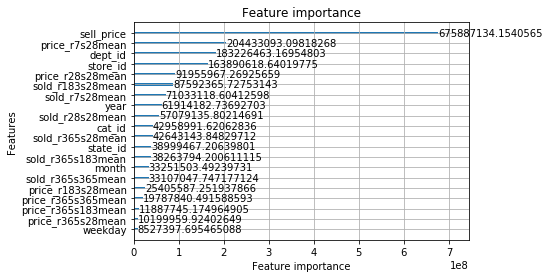

In [14]:
plt.figure(figsize=(15, 5))
lgb.plot_importance(model, importance_type='gain')

# Подготовка "станартного" вида валидации

In [15]:
val_pred = val_ds.copy()
val_pred['sold_predict'] = model.predict(val_ds[XS])
val_pred['d'] = val_pred.d.apply(lambda x: f'd_{x}')
val_pred = val_pred.pivot(index='id', columns='d', values='sold_predict')
val_pred = val_ds[ID_COLUMNS].drop_duplicates().merge(val_pred, on='id')

In [16]:
print('WRMSSE: ', metric.score(val_pred))

WRMSSE:  0.5743125420458745


# Отправка сабмита

In [17]:
submit_days = only_days_columns(val_pred)
submit_evaluation = val_pred[['id'] + submit_days]
submit_rename_dict = {
    col: f'F{i}' 
    for i, col in enumerate(only_days_columns(submit_evaluation), start=1)
}
submit_evaluation = submit_evaluation.rename(columns=submit_rename_dict)

submit_validation = submit_evaluation.copy()
submit_validation['id'] = submit_validation.id.str.replace('evaluation', 'validation')

submit = pd.concat([submit_evaluation, submit_validation])

In [18]:
submit.to_csv('submit.csv', index=False)

In [19]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submit.csv -m "Test pipeline"

100%|██████████████████████████████████████| 32.7M/32.7M [00:04<00:00, 7.59MB/s]
Successfully submitted to M5 Forecasting - Accuracy